Table 1 – summary of demographics – 
    - age
    - sex
    - duration of hearing loss
    - etiology
    - frequencies
    
Use median and IQR for continuous variables.
Table 2 Missing data across all the frequencies for the whole dataset

In [10]:
### Imports 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import i2bmi as i2bmi
import warnings
import seaborn as sns
import missingno as msno
import string

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from IPython.core.interactiveshell import InteractiveShell
from pprint import pprint

# Model selection, pipeline, and preprocessing steps
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Regression models
from sklearn.linear_model import LassoLarsCV, SGDRegressor, LogisticRegression, ElasticNetCV
from xgboost import XGBRegressor, XGBClassifier
#from lightgbm import LGBMRegressor
from pyearth import Earth  # MARS model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.dummy import DummyRegressor

# local imports
from tools.stats import simulate_imputations
from tools.stats import compare_estimators

from tools.ag_datasets import build_audiogram_dataset
from tools.ag_datasets import generate_sparse_dataset, find_parent_frequency
from tools.imputers import CustomIterativeImputer

# Show all cell outputs, not just the last
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)

In [11]:
# Jupyter notebook - widen cells
#i2bmi.jupyter_widen()

In [27]:
df = pd.read_excel('data/Audiograms.xlsx')

# miss_dict = {
#     'Unknown' : np.nan
# }

# df = df.replace(miss_dict)

cols = ['125hz', '250hz',
       '500hz',
        '750hz', 
        '1000hz', 
        '1500hz',
        '2000hz', '3000hz', '4000hz',
       '6000hz', '8000hz']

#df = df.dropna(thresh=1, subset=cols)

print(df.shape)
df = df.loc[df['Age'] > 17, :]
print(df.shape)

df = df.dropna(thresh=1, subset=cols)

print(df.shape)

df = df[cols]

print(df.dropna(thresh=6).shape)
print(df.dropna(thresh=5).shape)

(9980, 20)
(9626, 20)
(7451, 20)
(7362, 11)
(7399, 11)


<AxesSubplot:>

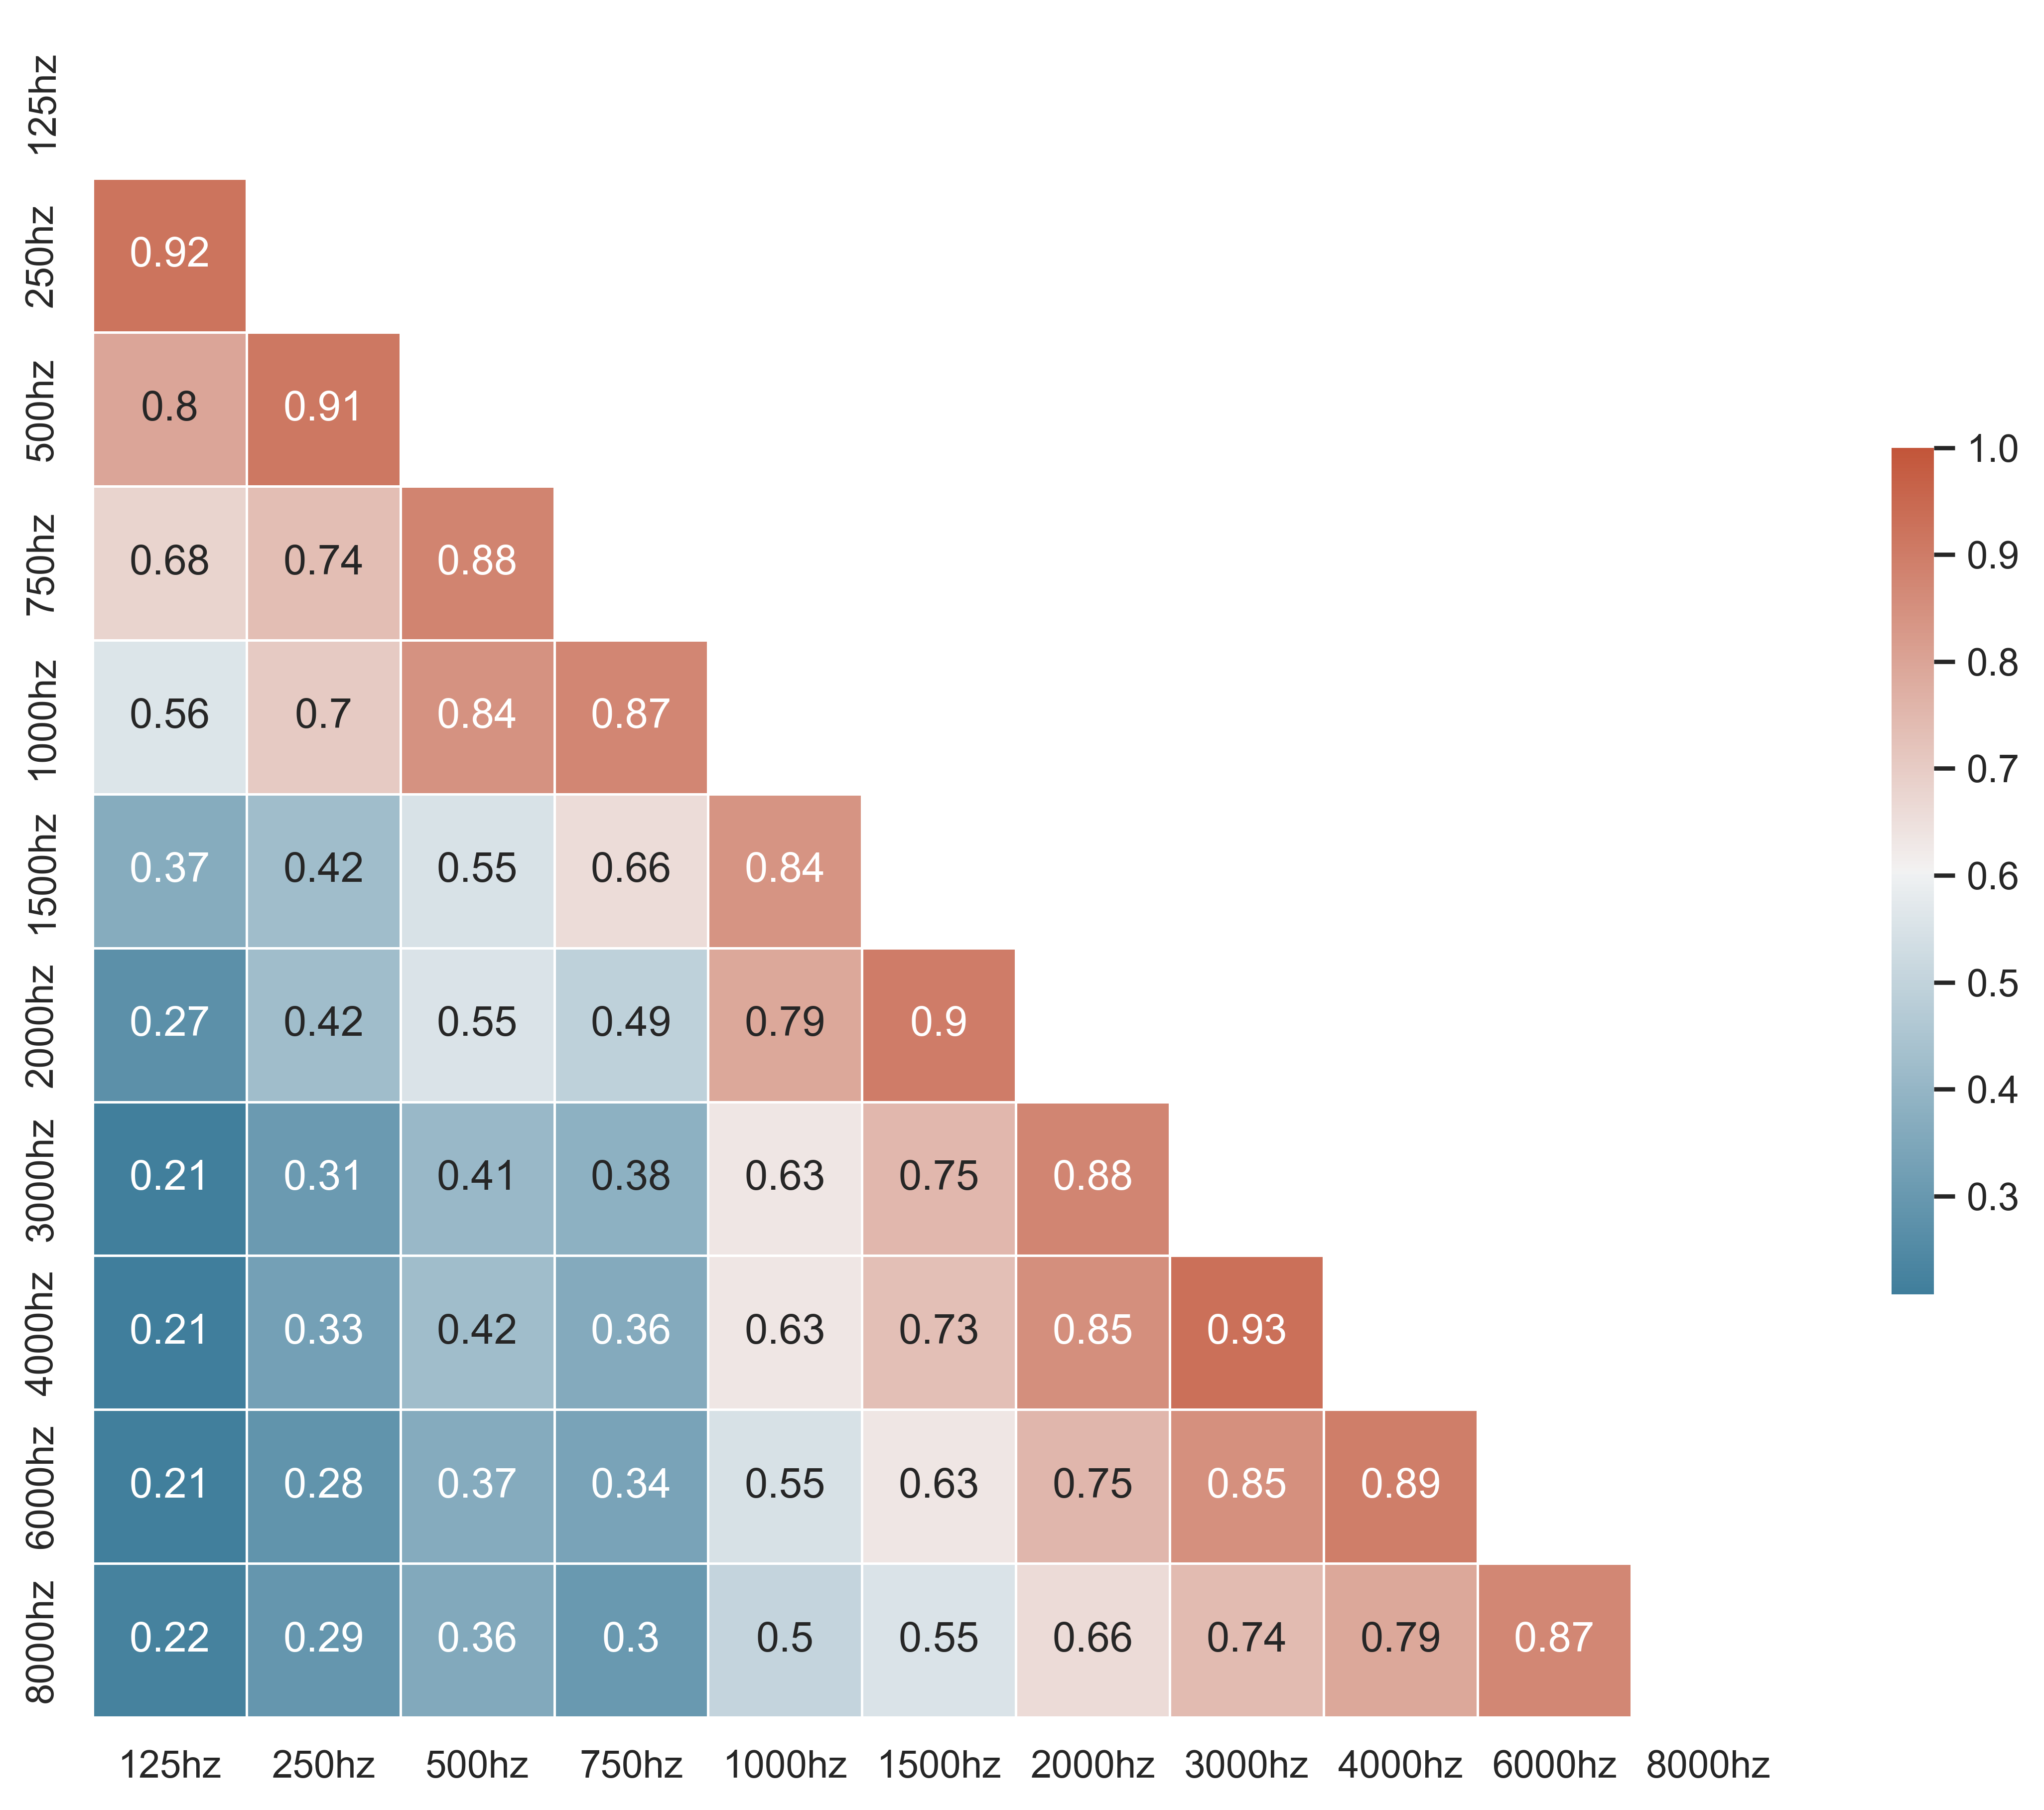

In [24]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9), dpi=500)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Missingness visualization

In [28]:
dft = df[cols]


dist = ['parent', 'random', 'skew-central', 'skew-terminal']
dname = ['Real-world', 'Random', 'Central', 'Terminal']

fig, axes = plt.subplots(2, 2, figsize=(15, 15), dpi=500)

_ = plt.subplots_adjust(
    left  = 0,  # the left side of the subplots of the figure
    right = 1,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.35,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

abc_size=20

for d, dn, ax in zip(dist, dname, axes.ravel()):
    
    X_train, y_train, m_train = generate_sparse_dataset(
                        parent=dft,
                        rate=4,
                        dist_type=d,
                        drop_proportion=1,
                        drop_max=None,
                        size=500,
                        prop=1
                    )
    
    _ = msno.matrix(X_train, ax=ax)
    
    _ = ax.set_xlabel(dn, fontsize=20)

    
for n, ax in enumerate(axes.flat):   
    _ = ax.text(-0.07, 1.05, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')


C:\Users\ShewLab\anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


In [ ]:
X_train, y_train, m_train = generate_sparse_dataset(
                    parent=dft,
                    rate=3,
                    dist_type='parent',
                    drop_proportion=1,
                    drop_max=None,
                    size=None,
                    prop=None
                )

<AxesSubplot:>

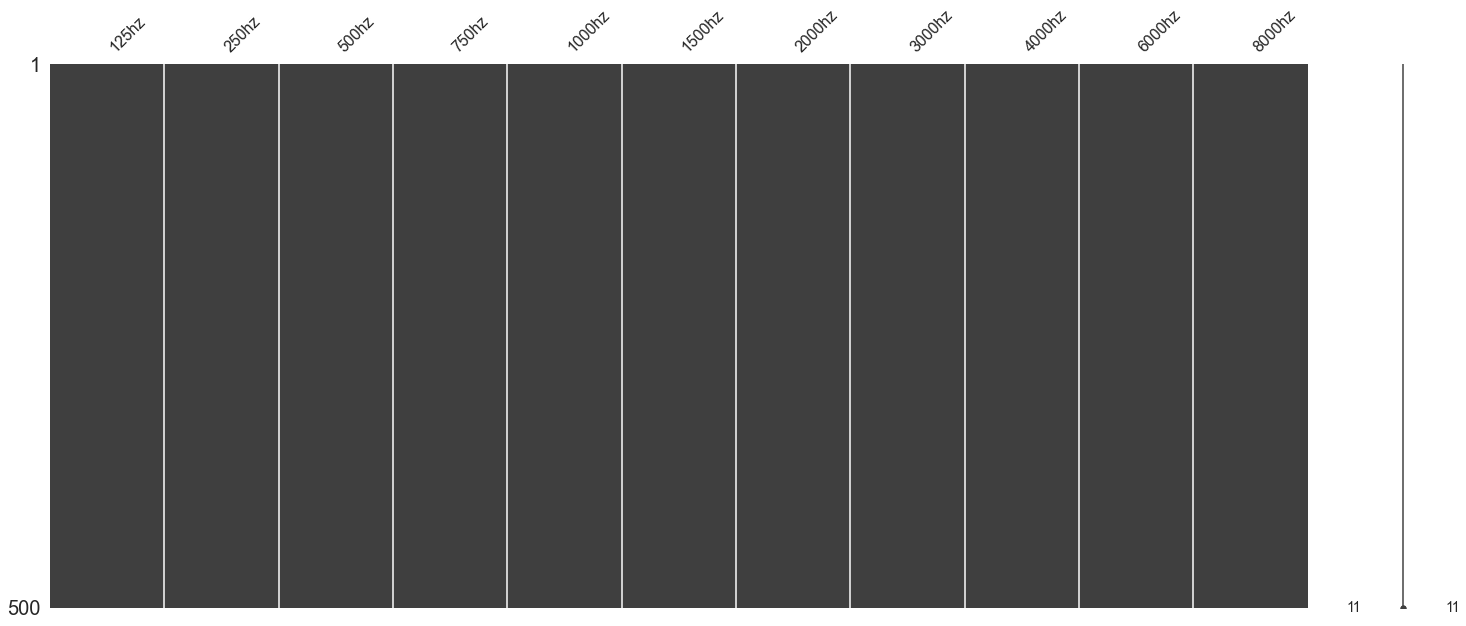

In [32]:
X_train, y_train, m_train = generate_sparse_dataset(
                    parent=y_train,
                    rate=rate,
                    dist_type=dist_type,
                    drop_proportion=drop_proportion,
                    drop_max=drop_max,
                    size=size,
                    prop=train_prop
                )

### Complete table (subplots)

In [46]:
### Make plotting dataframes

# Missing values
df_r = df[[
'Sex', 'Race', 'Age', 'HL_duration', 'Etiology', '125hz', '250hz',
       '500hz', '750hz', '1000hz', '1500hz', '2000hz', '3000hz', '4000hz',
       '6000hz', '8000hz', #'CNC', 'AzBio_Quiet', 'AzBio_5dB', 'AzBio_10dB'
    ]]
dataset_nullity = df_r.isnull()
df_missing = dataset_nullity.sum()
df_missing = dataset_nullity.mean()*100
df_missing = pd.DataFrame(df_missing).reset_index()
df_missing.rename(columns={'index':'Feature', 0:'% Missing'}, inplace=True)


# Audiograms
ag_cols = ['125hz', '250hz',
       '500hz', '750hz', '1000hz', '1500hz', '2000hz', '3000hz', '4000hz',
       '6000hz', '8000hz']
df_ag = df[ag_cols]
#df_ag.columns = [ '125', '250', '500', '750', '1000', '1500', '2000', '3000', '4000', '6000', '8000']

# Drop percents
num_drop_weights, col_drop_weights = find_parent_frequency(df_ag, min_col=1, verbose=0)
df_drops = pd.DataFrame([np.round(x*100, 1) for x in num_drop_weights]).reset_index()
df_drops.rename(columns={'index':'# Frequencies Missing', 0:'% Audiograms'}, inplace=True)

# Age
df_age = df[['Age', 'HL_duration']]

#df_spt = df[['CNC', 'AzBio_Quiet', 'AzBio_5dB', 'AzBio_10dB']]

# Etiology

eti_shortform = {
    'Medication/Radiation' : 'Meds/Rad',
    'Hereditary/Familial' : 'Hereditary',
    "Meniere's Disease" : "Meniere's",
    'Noise Exposure' : 'Noise',
    'Sudden Hearing Loss' : 'SSNHL',
    'Meningitis' : 'Infection',
    'Other' : '  Other',
    'Otosclerosis' : 'Otosclerosis',
    'Head Trauma' : 'Trauma',
    'Genetic' : 'Hereditary',
    'Acoustic Neuroma' : 'Ac. Neuroma'
}

df_e = df[['Etiology']].replace(eti_shortform)

df_eti = pd.DataFrame(df_e[['Etiology']].value_counts()).reset_index()
df_eti.rename(columns={'Etiology':'Etiology', 0:'# Audiograms'}, inplace=True)

# Sex
df_sex = pd.DataFrame(df[['Sex']].value_counts()).reset_index()
df_sex.rename(columns={0:'# Audiograms'}, inplace=True)

In [47]:
df.describe().round(1).drop('count').transpose().rename(columns={'50%':'median'})



,mean,std,min,25%,median,75%,max
Age,64.2,16.7,18.0,54.0,68.0,77.0,96.0
HL_duration,24.6,17.9,0.0,10.0,21.0,36.0,89.0
125hz,57.2,30.7,0.0,35.0,50.0,75.0,120.0
250hz,63.3,29.5,0.0,40.0,60.0,85.0,120.0
500hz,70.4,28.2,0.0,50.0,70.0,90.0,120.0
750hz,74.9,24.4,0.0,60.0,75.0,95.0,120.0
1000hz,80.8,25.8,0.0,65.0,80.0,100.0,120.0
1500hz,89.2,22.6,0.0,75.0,90.0,110.0,120.0
2000hz,90.6,25.7,0.0,75.0,95.0,115.0,120.0
3000hz,94.6,24.3,0.0,75.0,100.0,120.0,120.0


In [48]:
sns.set_theme()
sns.set_style("ticks", {'axes.grid': True})

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":12},style="white")
#sns.set(rc={'figure.figsize':(11.7,8.27)},style="white")
palette = sns.color_palette('pastel', 1)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(27, 16), dpi=500, sharey=False, squeeze=False)
plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.3,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

# for i, label in enumerate(('A', 'B', 'C', 'D', 'E', 'F')):
#     ax = fig.add_subplot(2,3,i+1)
#     ax.text(-0.1, 1.15, label, transform=ax.transAxes,
#       fontsize=16, fontweight='bold', va='top', ha='right')



font_subheader = {
    'size': 30,
    'weight': 'bold'
}

abc_size=35

ticksize = 20

# Plot audiogram drop #'s'
ax = axes[0, 0]
_ = sns.barplot(x=df_drops['# Frequencies Missing'], 
                 y=df_drops['% Audiograms'], 
                 data=df_drops,
                palette=palette,
               ax=ax)

_ = ax.set(ylim=[0, 24])
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)

_ = ax.set_ylabel('% Audiograms', fontdict=font_subheader)
_ = ax.set_xlabel('# Frequencies Missing', fontdict=font_subheader)


# for container in ax.containers:
#     _ = ax.bar_label(container, label_type='edge', fmt='%.1f')
    
    
# Plot age/hldur boxplot
ax = axes[0, 1]
_ = sns.boxplot(data = df_age, ax=ax, width=0.5, palette=palette)
_ = ax.set_xlabel('Feature', fontdict=font_subheader)
_ = ax.set_ylabel('Years', fontdict=font_subheader)
_ = ax.set(ylim=[0, 109])
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)

# Plot gender value count barchart
ax = axes[0, 2]
_ = sns.barplot(x=df_sex['Sex'], 
                 y=df_sex['# Audiograms'], 
                 data=df_sex,
                palette=palette,
               ax=ax)

_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)
# for container in ax.containers:
#     _ = ax.bar_label(container, label_type='center', fmt='%.0f')

_ = ax.set_xlabel('Sex', fontdict=font_subheader)
_ = ax.set_ylabel('# Audiograms', fontdict=font_subheader)
_ = ax.set_ylim((0, 4800))    
    
# Plot missing values barchart
ax = axes[1, 0]
_ = sns.barplot(x=df_missing['Feature'], 
                 y=df_missing['% Missing'], 
                 data=df_missing,
                palette=palette,
                ax=ax)

_ = ax.set(ylim=[0, 99])
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)


_ = ax.set_ylabel('% Missing', fontdict=font_subheader)
_ = ax.set_xlabel('Feature', fontdict=font_subheader, labelpad=2)

# for container in ax.containers:
#     _ = ax.bar_label(container, label_type='edge', fmt='%.1f')
    
    
# Plot audiogram descriptive statistics
ax = axes[1, 1]
_ = ax.set_ylim(130, -12)
_ = ax.set_ylabel('Hearing level (dB)', fontdict=font_subheader)
_ = ax.set_xlabel('Frequency', fontdict=font_subheader, labelpad=20)
_ = sns.boxplot(data = df_ag, palette=palette, ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)

    
# Plot etiology value count barchart
ax = axes[1, 2]
_ = sns.barplot(x=df_eti['Etiology'], 
                 y=df_eti['# Audiograms'], 
                 data=df_eti,
                palette=palette,
               ax=ax)

_ = ax.set_ylim((0, 5900))
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=ticksize)
_ = ax.tick_params(axis='y', labelsize=ticksize)
_ = ax.set_ylabel('# Audiograms', fontdict=font_subheader)
_ = ax.set_xlabel('Etiology', fontdict=font_subheader, labelpad=-11)



# for container in ax.containers:
#     _ = ax.bar_label(container, label_type='edge', fmt='%.0f')

    
    
#title_list = ['A', 'B', 'C', 'D', 'E', 'F']
#title_list = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
# title_list = ['a', 'b', 'c', 'd', 'e', 'f']
# for title, ax in zip(title_list, axes.ravel()):
#     _ = ax.set_title(title, fontsize='20', loc='left', pad=7, weight='bold')


axs = axes.flat

for n, ax in enumerate(axs):   
    
    
    _ = ax.text(-0.09, 0.98, (string.ascii_lowercase[n] + ')'), transform=ax.transAxes, 
            size=abc_size, weight='bold')

    


### Table of missing value percents

In [30]:
# Numerically Calculate Missing Values
dataset_nullity = df.isnull()

#print(dataset_nullity)
missing_values_sum = dataset_nullity.sum()

#with pd.option_context('display.max_rows', 100):
#  print('Total Missing Values: \n', missing_values_sum)

# ###As a Percentage
missing_values_percent = dataset_nullity.mean()*100
# with pd.option_context('display.max_rows', 100):
#     print('Percentage of Missing Values:\n', missing_values_percent.round(1))

missing_values_percent = pd.DataFrame(missing_values_percent).reset_index()

missing_values_percent.rename(columns={'index':'Feature', 0:'% Missing'}, inplace=True)

In [36]:
missing_values_percent

,Feature,% Missing
0,Sex,0.000000
1,Race,0.000000
2,Age,0.000000
3,HL_duration,8.757940
4,Etiology,0.000000
5,125hz,45.033113
6,250hz,0.202730
7,500hz,0.162184
8,750hz,65.414245
9,1000hz,0.148669


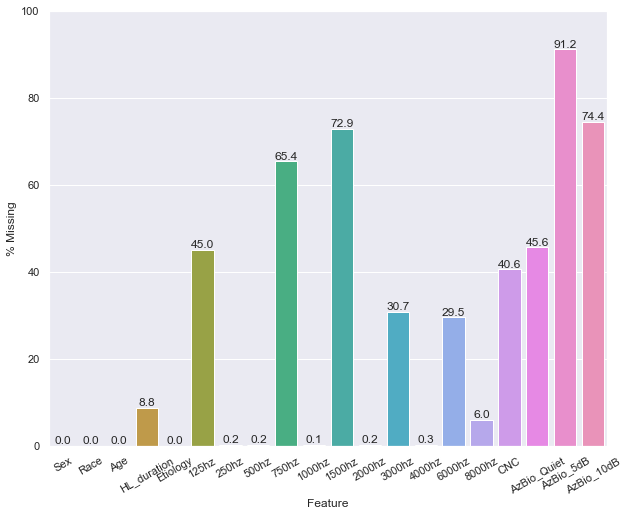

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=False, squeeze=False)

sns.set_theme()
palette = sns.color_palette('bright', missing_values_percent.shape[0])
sns.set_style("ticks", {'axes.grid': True})



for ax in axes.ravel():

    ax = sns.barplot(x=missing_values_percent['Feature'], 
                     y=missing_values_percent['% Missing'], 
                     data=missing_values_percent)


    _ = ax.set(
            ylim=[0, 100],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation =30)

    for container in ax.containers:
        _ = ax.bar_label(container, label_type='edge', fmt='%.1f')

### Table of % of audiograms with X number dropped

In [32]:
ag_cols = [ '125hz', '250hz', '500hz',
       '750hz', '1000hz', '1500hz', '2000hz', '3000hz', '4000hz', '6000hz',
       '8000hz']

df_ag = df[ag_cols]

num_drop_weights, col_drop_weights = find_parent_frequency(df_ag, min_col=1, verbose=0)

df_drops = pd.DataFrame([np.round(x*100, 1) for x in num_drop_weights]).reset_index()
df_drops.rename(columns={'index':'# dropped', 0:'% of audiograms'}, inplace=True)


KeyError: '# dropped'

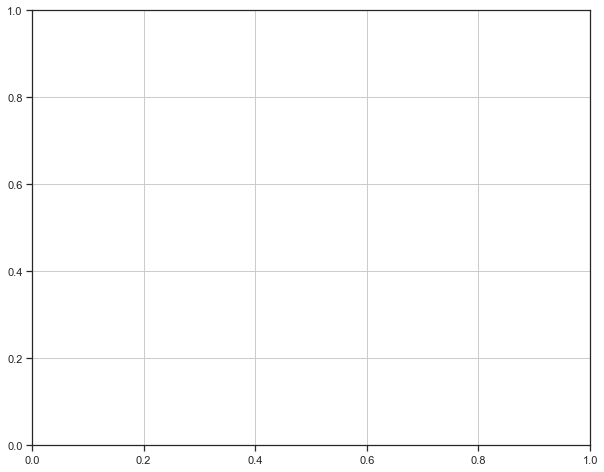

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=False, squeeze=False)

sns.set_theme()
palette = sns.color_palette('bright', missing_values_percent.shape[0])
sns.set_style("ticks", {'axes.grid': True})



for ax in axes.ravel():

    ax = sns.barplot(x=df_ag['# dropped'], 
                     y=df_ag['% of audiograms'], 
                     data=df_ag)


    _ = ax.set(
            ylim=[0, 25],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation =0)

    for container in ax.containers:
        _ = ax.bar_label(container, label_type='edge', fmt='%.1f')

### Descriptive statistics

(130.0, -10.0)

Text(0, 0.5, 'Hearing level (dB)')

Text(0.5, 0, 'Frequency')

<AxesSubplot:xlabel='Frequency', ylabel='Hearing level (dB)'>

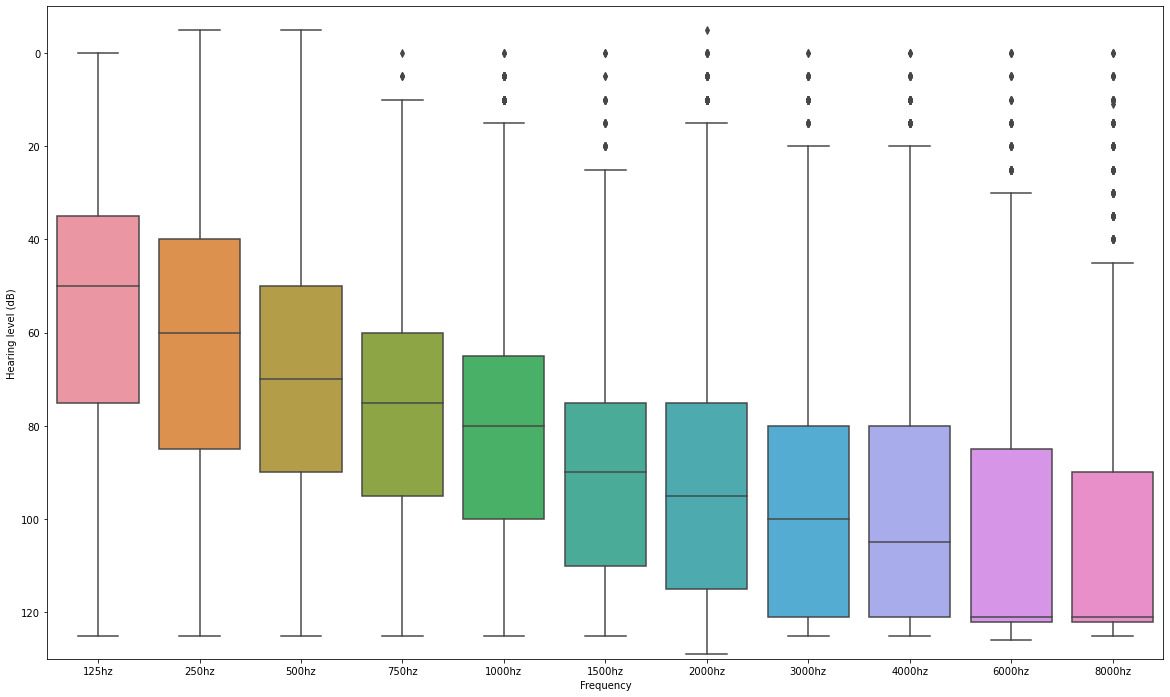

In [4]:
ag_cols = [ '125hz', '250hz', '500hz',
       '750hz', '1000hz', '1500hz', '2000hz', '3000hz', '4000hz', '6000hz',
       '8000hz']

df_ag = df[ag_cols]

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_ylim(130, -10)
ax.set_ylabel('Hearing level (dB)')
ax.set_xlabel('Frequency')

#bp = df_ag.boxplot(figsize=(20, 12), ax=ax)

sns.boxplot(data = df_ag, ax=ax)

### Age/HLdur

In [70]:
df_ = df[['Age', 'HL duration']]


df_age = df[['Age']]



<AxesSubplot:>

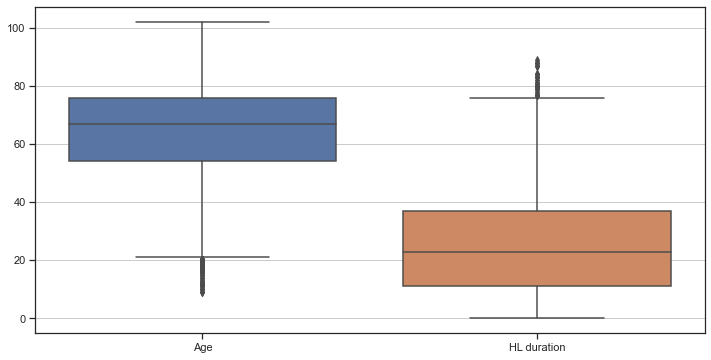

In [86]:

ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

#sns.lineplot(data = df_['Sex'], marker='o', sort = False, ax=ax1)
#ax2 = ax1.twinx()

sns.boxplot(data = df_, ax=ax1)

### Categoricals

<AxesSubplot:xlabel='Etiology of Hearing Loss'>

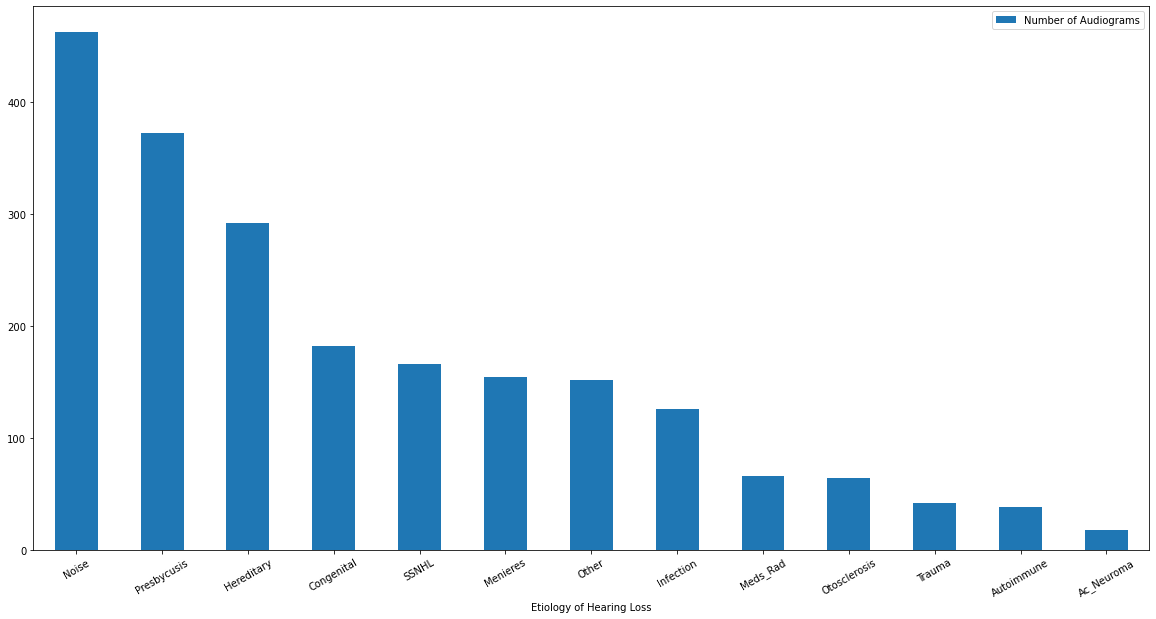

In [4]:
df_cat = pd.DataFrame(df[['Etiology']].value_counts()).reset_index()
df_cat.rename(columns={'Etiology':'Etiology of Hearing Loss', 0:'Number of Audiograms'}, inplace=True)

df_cat.plot.bar(x='Etiology of Hearing Loss', y='Number of Audiograms', rot=30, figsize=(20, 10))

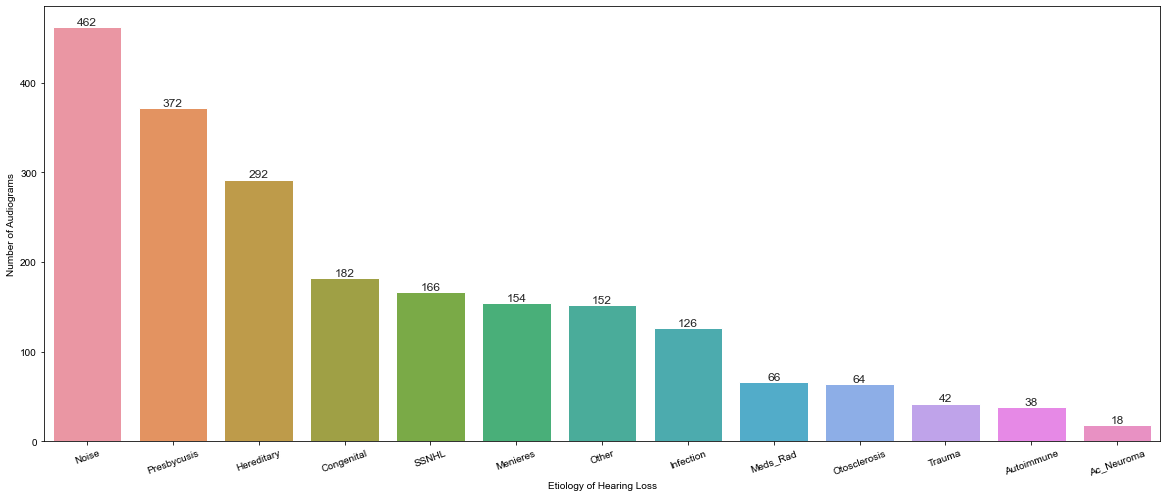

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=False, squeeze=False)

sns.set_theme()
palette = sns.color_palette('bright', df_cat.shape[0])
sns.set_style("ticks", {'axes.grid': True})

for ax in axes.ravel():

    ax = sns.barplot(x=df_cat['Etiology of Hearing Loss'], 
                     y=df_cat['Number of Audiograms'], 
                     data=df_cat)

    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation =20)

    for container in ax.containers:
        _ = ax.bar_label(container, label_type='edge', fmt='%.0f')

In [22]:
vc = pd.DataFrame(df[['Etiology']].value_counts()).reset_index()

In [25]:
vc[1] = vc[0]*100/7451

In [26]:
vc

,Etiology,0,1
0,Unknown,5812,78.002953
1,Noise,357,4.791303
2,Presbycusis,284,3.811569
3,Hereditary,238,3.194202
4,SSNHL,137,1.838679
5,Menieres,132,1.771574
6,Other,127,1.704469
7,Congenital,101,1.355523
8,Infection,84,1.127365
9,Meds_Rad,51,0.684472


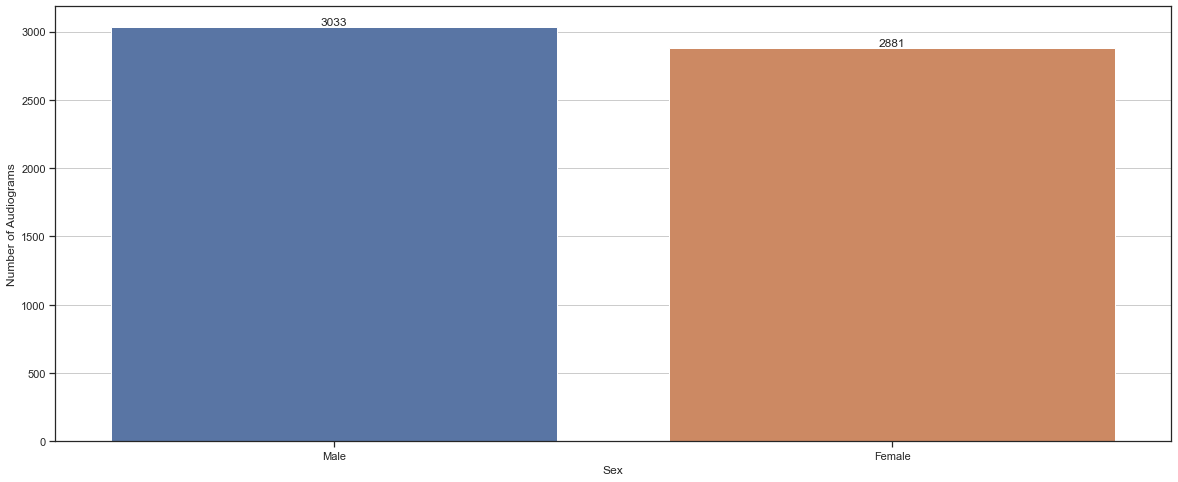

In [92]:
df_s = pd.DataFrame(df[['Sex']].value_counts()).reset_index()
df_s.rename(columns={0:'Number of Audiograms'}, inplace=True)




fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=False, squeeze=False)

sns.set_theme()
palette = sns.color_palette('bright', df_s.shape[0])
sns.set_style("ticks", {'axes.grid': True})

for ax in axes.ravel():

    ax = sns.barplot(x=df_s['Sex'], 
                     y=df_s['Number of Audiograms'], 
                     data=df_s)

    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation =0)

    for container in ax.containers:
        _ = ax.bar_label(container, label_type='edge', fmt='%.0f')

### ...

In [39]:
print(df.describe().round(1).transpose())

                        count   mean   std   min   25%    50%    75%    max
Age                    1303.0   62.0  15.5  18.0  54.0   65.0   73.0   91.0
Hearing loss duration  1300.0   26.1  16.9   0.0  13.0   24.0   38.0   79.0
125hz                  1303.0   51.1  30.9   0.0  30.0   45.0   65.0  125.0
250hz                  1303.0   54.8  29.6   0.0  30.0   50.0   70.0  125.0
500hz                  1303.0   63.5  28.0   5.0  45.0   60.0   80.0  125.0
750hz                  1303.0   72.1  25.3   0.0  55.0   70.0   90.0  125.0
1000hz                 1303.0   79.9  23.7   0.0  65.0   80.0   95.0  125.0
1500hz                 1303.0   89.6  21.6   0.0  75.0   90.0  105.0  125.0
2000hz                 1303.0   96.5  21.5   5.0  80.0  100.0  115.0  125.0
3000hz                 1303.0  101.0  21.0   5.0  90.0  105.0  121.0  125.0
4000hz                 1303.0  102.9  20.4   0.0  90.0  110.0  121.0  125.0
6000hz                 1303.0  105.5  20.8   0.0  95.0  121.0  121.0  125.0
8000hz      

In [5]:
print('Etiology value counts')
print(df['Etiology'].value_counts())

Etiology value counts
Unknown                            1318
Noise Exposure                      283
Hereditary/Familial                 181
Presbycusis                         167
Other                               130
Meniere's Disease                    89
Sudden Hearing Loss                  51
Ototoxic Medication / Radiation      43
Otosclerosis                         43
Congenital                           43
Genetic                              41
Infection                            40
Autoimmune                           28
Meningitis                           23
Head Trauma                          14
Acoustic Neuroma                     11
Name: Etiology, dtype: int64


In [41]:
print('Sex value counts')
print(df['Sex'].value_counts())

Sex value counts
Male      651
Female    588
Name: Sex, dtype: int64
